In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataloader import default_collate
from torchvision import datasets, transforms
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

# plot variational posterior
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as tck

import wandb # weights and biases for tracking of metrics

import os 
os.environ['WANDB_NOTEBOOK_NAME'] = 's-vae' # for tracking of the notebook name

from torchvision.utils import make_grid
from code import *
from hyperspherical_vae.distributions import HypersphericalUniform
from hyperspherical_vae.distributions import VonMisesFisher

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and pprint config

In [2]:
import yaml
import pprint


stream = open("config_s-vae.yaml", 'r')
config = yaml.load(stream, Loader = yaml.FullLoader)

# # This is for the MLP of the conditioner
# HIDDEN_DIM_BASE_MLP = config['HIDDEN_DIM_BASE_MLP']

# # This is for the MLPs of the flow
# HIDDEN_DIM_SPLINE_MLP = config['HIDDEN_DIM_SPLINE_MLP']
# HIDDEN_DIM_MOEBIUS_MLP = config['HIDDEN_DIM_MOEBIUS_MLP']
# HIDDEN_DIM_ROTATION_MLP = config['HIDDEN_DIM_ROTATION_MLP']

# the variables are hard coded within the python files.
# Thus we read them via from .. import * and store them in the config

config['HIDDEN_DIM_BASE_MLP'] = HIDDEN_DIM_BASE_MLP
config['HIDDEN_DIM_SPLINE_MLP'] = HIDDEN_DIM_SPLINE_MLP
config['HIDDEN_DIM_MOEBIUS_MLP'] = HIDDEN_DIM_MOEBIUS_MLP
config['HIDDEN_DIM_ROTATION_MLP'] = HIDDEN_DIM_ROTATION_MLP

# sample images via VAE
nr_rows_to_sample = config['NR_ROWS_TO_SAMPLE']

### Set globabl variables and load data
h_dim = config['H_DIM']
z_dim = config['Z_DIM']

batch_size = config['BATCH_SIZE']

num_flows = config['NUM_FLOWS']
num_centers = config['NUM_CENTERS']
num_bins = config['NUM_BINS']

epochs = config['epochs']
eval_iter = config['eval_iter']
# sample_images_iter = config['sample_images_iter']
test_set_eval_iter = config['test_set_eval_iter']
lookahead = config['lookahead']

lr = config['lr']
weight_decay = config['weight_decay']

# load the data
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./s_vae_pytorch/data', train=True, download=True, 
                                                          transform=transforms.ToTensor()),
                                          batch_size=batch_size, 
                                          shuffle=True)


test_loader = torch.utils.data.DataLoader(datasets.MNIST('./s_vae_pytorch/data', train=False, download=True,
                                                         transform=transforms.ToTensor()), 
                                          batch_size=int(1e5))

# to plot every metric plot I can dream of
config['iters_per_epoch'] = len(train_loader)

pp = pprint.PrettyPrinter(indent=1)
pp.pprint(config)

PROJECT_NAME = f'S_VAE_DIM_{z_dim}'


{'BATCH_SIZE': 256,
 'HIDDEN_DIM_BASE_MLP': 128,
 'HIDDEN_DIM_MOEBIUS_MLP': 128,
 'HIDDEN_DIM_ROTATION_MLP': 128,
 'HIDDEN_DIM_SPLINE_MLP': 128,
 'H_DIM': 128,
 'NR_ROWS_TO_SAMPLE': 5,
 'NUM_BINS': 16,
 'NUM_CENTERS': 8,
 'NUM_FLOWS': 2,
 'Z_DIM': 5,
 'epochs': 1,
 'eval_iter': 25,
 'iters_per_epoch': 235,
 'lookahead': 20,
 'lr': 0.001,
 'test_set_eval_iter': 50,
 'weight_decay': 0.01}


In [3]:
class ModelVAE(torch.nn.Module):
    
    def __init__(self, 
                 num_dim_data, 
                 h_dim, 
                 z_dim, 
                 num_bins,
                 num_centers, 
                 num_flows=2,
                 activation=F.relu, 
                 distribution='normal'):
        
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        
        
        if self.distribution in ('normal','vmf'):
            # 2 hidden layers encoder
            self.fc_e0 = nn.Linear(num_dim_data, h_dim * 2)
            self.fc_e1 = nn.Linear(h_dim * 2, h_dim)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var =  nn.Linear(h_dim, z_dim)
            
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var = nn.Linear(h_dim, 1)
                
                
        elif self.distribution == 'coupling_moebius_flow':
            # Init flow distribution
            self.flow = Coupling_Flow(num_flows = num_flows, 
                                      flow_type = 'moebius', 
                                      num_dim_data = z_dim,
                                      num_centers = num_centers, 
                                      num_dim_conditioner = num_dim_data)   
            
        elif self.distribution == 'coupling_spline_flow':
            # Init flow distribution
            self.flow = Coupling_Flow(num_flows = num_flows,
                                      flow_type = 'spline', 
                                      num_dim_data = z_dim,                                    
                                      num_bins = num_bins, 
                                      num_dim_conditioner = num_dim_data)
            
        elif self.distribution == 'cylindrical_moebius_flow':
            # Init flow distribution
            self.flow = Cylindrical_Flow(num_flows = 1,
                                         num_bins=num_bins, 
                                         flow_type = 'moebius', 
                                         num_dim_data = z_dim,
                                         mask_type='coupling',
                                         num_dim_conditioner = num_dim_data, 
                                         num_centers = num_centers)
            
        elif self.distribution == 'cylindrical_spline_flow':
            # Init flow distribution
            self.flow = Cylindrical_Flow(num_flows = 1,
                                         num_bins=num_bins, 
                                         flow_type = 'spline', 
                                         num_dim_data = z_dim,
                                         mask_type='coupling',
                                         num_dim_conditioner = num_dim_data)           
            
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(z_dim, h_dim)
        self.fc_d1 = nn.Linear(h_dim, h_dim * 2)
        self.fc_logits = nn.Linear(h_dim * 2, 784)

    def encode(self, x_in):
        
        batch_size = x_in.shape[0]
        
        if self.distribution == 'normal':
            
            # 2 hidden layers encoder
            x = self.activation(self.fc_e0(x_in))
            x = self.activation(self.fc_e1(x))
            
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
            return z_mean, z_var
            
        elif self.distribution == 'vmf':
            
            # 2 hidden layers encoder
            x = self.activation(self.fc_e0(x_in))
            x = self.activation(self.fc_e1(x))
            
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
             
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
            return z_mean, z_var
    
        elif 'flow' in self.distribution:
            
            # sample z_0 sim q_0 and push through flow
            
            # sample for each data point individually
            z_0 = HypersphericalUniform(self.z_dim - 1).sample(shape = x_in.shape[0]).to(device)
            
            # generated sample distributed according to flow
            z, sldj, x_conditioner = self.flow(x = z_0, x_conditioner = x_in)
            
            return z, sldj
            
        else:
            raise NotImplemented
        

        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):

        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
            
        elif self.distribution == 'vmf':
            
            # the device for the VMF distribution is inherited from the type of z_mean
            q_z = VonMisesFisher(z_mean, z_var)
            
            p_z = HypersphericalUniform(self.z_dim - 1)
            p_z.device = device # set device manually

        return q_z, p_z
        
    def forward(self, x): 
        """
        Args: 
            x torch.tensor (batch, n)
        Returns:
            if normal vmf 
            
            elif emiel
                z torch.tensor (batch, z_dim) latent space variable
                x_ paramters of probabilitic decoder
                
        """
        
        if self.distribution in ('normal','vmf'):
            
            z_mean, z_var = self.encode(x)
            q_z, p_z = self.reparameterize(z_mean, z_var)
            
            z = q_z.rsample()
                
        elif 'flow' in self.distribution:
            
            z, sldj = self.encode(x)
            
        # note that decoder does not contain sigmoid layer
        # this is part of BCE with logits loss
        x_ = self.decode(z) # x_ are the parameters of the probabilistic decoder 
        
        if self.distribution in ('normal','vmf'):
            return (z_mean, z_var), (q_z, p_z), z, x_
        
        elif 'flow' in self.distribution:
            return z, sldj, x_
    
    
    def sample(self, nr_rows):
        
        """
        Sample n_samples from the model. Return both the sampled images
        (from bernoulli) and the means for these bernoullis (as these are
        used to plot the data manifold).
        """

        nr_samples = nr_rows ** 2

        # generate z_0
        
        if self.distribution in ('normal'):
            
            # NOTE sample from prior on latent space which is N(0,1)
            # samples always (batch,z_dim)
            z = torch.randn((nr_samples, self.z_dim)).to(device)

        elif self.distribution == 'vmf' or 'flow' in self.distribution:
            
            z = HypersphericalUniform(self.z_dim - 1).sample(nr_samples).to(device)
        
        # unnormalized parameters of Bernoulli distribution
        im_means = self.decode(z).reshape(-1,1,28,28)
            
        # normalized parameters of Bernoulli distribution to [0, 1]
        im_means = torch.sigmoid(im_means)      
        
        sampled_ims = torch.bernoulli(im_means)
        grid = make_grid(sampled_ims, nr_rows) 
        means_grid = make_grid(im_means, nr_rows)

        numpy_grid = grid.cpu().detach().numpy().transpose(1,2,0)
        numpy_means_grid = means_grid.cpu().detach().numpy().transpose(1,2,0)
        
        fig = plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.title('Sampled digits')
        plt.imshow(1 - numpy_grid) 
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Image means')
        plt.imshow(1 - numpy_means_grid)
        
        plt.axis('off')
        plt.show()

        return numpy_grid, numpy_means_grid
    
    @property
    def get_flow_model(self):
        assert 'flow' in self.distribution , "only variational posterior as a flow"
        return self.flow
    
    @property
    def model_type(self):
        return self.distribution

    @property
    def num_dim_data(self):
        return self.z_dim
    
    
    def get_variational_posterior(self, x):
        assert self.distribution in ('normal','vmf'), "only variational posterior as a vmf or gaussian"
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        return q_z
            
        
    



In [4]:
def train_VAE(model, 
              optimizer, 
              train_loader, 
              config,
              epochs, 
              eval_iter, 
              model_name):
              
    # init weights and biases tracking
    ts = time.strftime('%m%d_%H%M%S', time.localtime(time.time()))
    
    z_dim = config['Z_DIM']
    
    if 'moebius' in model.distribution:
        name = f'{model_name}_NC_{num_centers}_NF_{num_flows}'
        
    elif 'spline' in model.distribution:
        name = f'{model_name}_NB_{num_bins}_NF_{num_flows}'
    
    elif 'normal' == model.distribution:
        name = 'N_VAE'
    elif 'vmf' == model.distribution:
        name = 'S_VAE'        
    
    wandb.init(project=f'{PROJECT_NAME}',
               config=config,
               name=name,
               id=ts,
               magic=True)
    
    # Magic, to track gradients of model
    wandb.watch(model, log = 'all')
    
    wandb.run.summary["run_id"] = ts
    wandb.run.summary["z_dim"] = z_dim
    
    best_elbo = 1e3
    epoch_of_best_run = 0
    break_out = False
    
    print('##### Model ######')
    print(model)
    print('##################\n')
    
    print('##### Config #####')
    pp = pprint.PrettyPrinter(indent=1)
    pp.pprint(config)
    print('##################\n')
    
    def store_model(best_vs_last):
        
        state = {
            'epoch': epoch,
            'batch_index': batch_idx,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'config': config
        }                        

        torch.save(state, f"models_s_vae/{best_vs_last}_{model_name}_model.t7")
        wandb.save(f"models_s_vae/{best_vs_last}{model_name}_model.t7")         

    for epoch in range(epochs):
        
        print(f'Epoch: {epoch}/{epochs}')
        
        # sample images to begin of each epoch
        image, image_means = model.sample(nr_rows_to_sample)
        wandb.log({"Sampled image" : wandb.Image(1 - image, caption = f'Epoch : {epoch}, iter : {0}')}, commit=False)
        wandb.log({"Image means" : wandb.Image(1 - image_means, caption = f'Epoch : {epoch}, iter : {0}')}, commit=False)
        
        for batch_idx, (x_mb, y_mb) in enumerate(train_loader):
        
                optimizer.zero_grad()
                
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)                

                # dynamic binarization
                # original paper https://www.cs.toronto.edu/~rsalakhu/papers/dbn_ais.pdf  
                
                # have to send uniform distribution also to device
                x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape).to(device)).float()
                
                if model.distribution in ('normal','vmf'):
                    
                    # psi are the parameters of the bernoulli distribution Bern(x | psi)
                    _, (q_z, p_z), _, psi = model(x_mb.reshape(-1, 784))

                elif 'flow' in model.distribution:
                    z, sldj, psi = model(x_mb.reshape(-1, 784))
                    
                else:
                    raise Exception('Not implemented')
                    
                # BCEWithLogits is BCE with sigmoid and 
                # Loss_BCE(x,y) = - { y log[sigmoid(x)] + (1 - y) log[1 - sigmoid(x)] } # NOTE THE MINUS
                # that means the output of the model, which is the decoder, gets mapped to x, which itself gets mapped to [0,1] via sigmoid

                if model.distribution == 'normal':

                    loss_recon = nn.BCEWithLogitsLoss(reduction='none')(psi, x_mb.reshape(-1, 784)).sum(-1).mean()
                    loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()

                elif model.distribution == 'vmf':

                    # q_z is vmf
                    # p_z is hyperspherical uniform

                    loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
                    loss_recon = nn.BCEWithLogitsLoss(reduction='none')(psi, x_mb.reshape(-1, 784)).sum(-1).mean()

                else:
                    
                    loss_recon = loss_func_recon(psi, x_mb.reshape(-1, 784))
                    loss_KL = loss_func_KL(sldj)
                    
                loss = loss_recon + loss_KL
                
                loss.backward()       
                optimizer.step()
                
                # test set evaluation
                if batch_idx % test_set_eval_iter == 0:                  
                    
                    loss_test, loss_recon_test, loss_KL_test = test(model, 
                                                                    test_loader,
                                                                    epoch,
                                                                    batch_idx,
                                                                    max_steps=len(train_loader))

                    wandb.log({"ELBO_test": loss_test,
                               "loss_recon_test": loss_recon_test,
                               "loss_KL_test": loss_KL_test}, 
                               commit = False)

                
                # print metrics to console every {eval_iter} steps
                if batch_idx % eval_iter == 0:

                    print(f'Epoch: {epoch}/{epochs-1}, i / N: {batch_idx}/{len(train_loader)} with loss {loss:.2f} and recon loss {loss_recon:.2f} and KL loss {loss_KL:.2f}')   
                
                
                # save the best model but do not save any model during the first 50 iterations
                if not (epoch == 0 and batch_idx < 50):
                    
                    if loss_test < best_elbo:
                        
                        # store the whole state includ. optimizer, epoch etc. This way we can continue training
                        store_model(best_vs_last='best')
            
                        best_elbo = loss_test
                        epoch_of_best_run = epoch

                        wandb.run.summary["ELBO_best_test"] = best_elbo
                        wandb.run.summary["loss_recon_best_test"] = loss_recon_test
                        wandb.run.summary["loss_KL_best_test"] = loss_KL_test
                        
                        wandb.run.summary["epoch_of_best_test_ELBO"] = epoch_of_best_run
                        wandb.run.summary["batch_id_of_best_test_ELBO"] = batch_idx
                        
                
                # store the metrics in the log. Store the actual metrics at last because of commit False
                wandb.log({"ELBO": loss,
                           "loss_recon": loss_recon,
                           "loss_KL": loss_KL})
                
                
        # if there was no improvement after a certain amount of epochs terminate training    
        if epoch - epoch_of_best_run >= config['lookahead']:
            print()
            print('#### EARLY STOPPING ####')
            print(f'at epoch {epoch} and batch_id {batch_idx}')
            print('########################')
            print()
            break                     
    
    # store after last epoch
    store_model(best_vs_last='last')
    wandb.run.summary["last_epoch"] = epoch
    
    

def eval_var_posterior(model, nr_datapoints):
    """Evaluate flow variational posterior with monte carlo integration"""
    flow_posterior = model.get_flow_model
    
    z = torch.randn(nr_datapoints, model.num_dim_data).to(device)
    z = z / torch.norm(z, dim=1, keepdim=True)

    random_conditioner = torch.rand(1,784).repeat(nr_datapoints,1).to(device)
    
    out, ldj, _ = flow_posterior(x=z, x_conditioner=random_conditioner)  
    
    return ldj

    
                
def test(model, 
         test_loader,
         epoch,
         batch_idx,
         max_steps):
    
    model.eval()
    
    for x_mb, y_mb in test_loader:
        
        x_mb = x_mb.to(device)
        y_mb = y_mb.to(device)
        
        # dynamic binarization

        # original paper https://www.cs.toronto.edu/~rsalakhu/papers/dbn_ais.pdf      
        # they don't say why they do it

        x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape).to(device)).float()

        if model.distribution in ('normal','vmf'):

            _, (q_z, p_z), _, psi = model(x_mb.reshape(-1, 784))

        elif 'flow' in model.distribution:

            z, sldj, psi = model(x_mb.reshape(-1, 784))

        else:

            raise Exception('Not implemented')

        # BCEWithLogits is BCE with sigmoid and 
        # Loss_BCE(x,y) = - { y log[sigmoid(x)] + (1 - y) log[1 - sigmoid(x)] } # NOTE THE MINUS
        # that means the output of the model, which is the decoder, gets mapped to x, which itself gets mapped to [0,1] via sigmoid

        if model.distribution == 'normal':

            loss_recon = nn.BCEWithLogitsLoss(reduction='none')(psi, x_mb.reshape(-1, 784)).sum(-1).mean()
            loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()

        elif model.distribution == 'vmf':

            loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
            loss_recon = nn.BCEWithLogitsLoss(reduction='none')(psi, x_mb.reshape(-1, 784)).sum(-1).mean()

        else:

            loss_recon = loss_func_recon(psi, x_mb.reshape(-1, 784))
            loss_KL = loss_func_KL(sldj)

            nr_datapoints = int(5e4)
            ldj = eval_var_posterior(model, nr_datapoints)
            
        loss = loss_recon + loss_KL
        
        print()
        print(f'Evaluation on test set with {x_mb.shape[0]} samples')
        print(f'Epoch: {epoch}/{epochs-1} i / N: {batch_idx}/{len(train_loader)} with loss {loss:.2f} and recon loss {loss_recon:.2f} and KL loss {loss_KL:.2f}')   
        
        if 'flow' in model.distribution:
            
            print(f'MC integration: {torch.mean(torch.exp(ldj)):.2f} based on {nr_datapoints} datapoints')
            wandb.log({"MC integration": torch.mean(torch.exp(ldj))}, commit = False)
            
        print()               
        
        model.train()
        
        return loss, loss_recon, loss_KL



### Training of the 6 different models

##### Coupling Moebius Flow VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (flow): Coupling_Flow(
    (mlp_body): MLP_body(
      (nn): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (scale): ModuleList(
      (0): Rotation(
        (householder_params): MLP(
          (nn): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=36, bias=True)
          )
        )
      )
      (1): Coupling(
        (circle_transf): Moebius_Flow(
          (param_predictor): MLP(
            (nn): Sequential(
              (0): Linear(in_features=130, out_features=128, bias=True)
              (1): ReLU()
              (2): Linear(in_features=128, out_features=33, bias=True)
            )
          )
        )
        (cond_rotation): Rotation(
          (householder_params): MLP(
            (nn): Sequentia

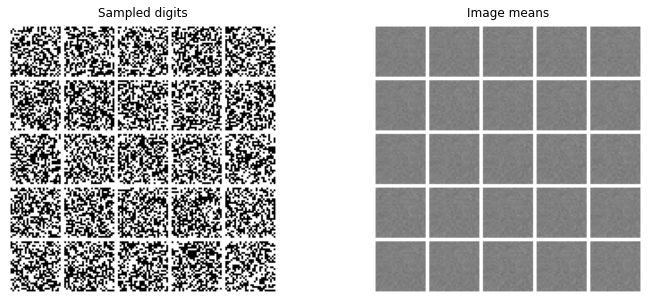


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 537.23 and recon loss 537.23 and KL loss -0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 0/235 with loss 543.27 and recon loss 543.27 and KL loss -0.00
Epoch: 0/0, i / N: 25/235 with loss 227.38 and recon loss 227.38 and KL loss 0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 208.33 and recon loss 208.33 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 50/235 with loss 206.83 and recon loss 206.83 and KL loss -0.00
Epoch: 0/0, i / N: 75/235 with loss 204.66 and recon loss 204.66 and KL loss -0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 206.31 and recon loss 206.31 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 100/235 with loss 207.62 and recon loss 207.62 and KL loss -0.00
Epoch: 0/0, i / N: 125/235 with loss 203.15 and recon loss 203.15 and

In [5]:
coupling_moeb_flow = ModelVAE(num_dim_data = 784, 
                              h_dim=h_dim, 
                              z_dim=z_dim + 1, 
                              num_bins=num_bins,
                              num_centers=num_centers,
                              num_flows=num_flows,
                              distribution='coupling_moebius_flow')

coupling_moeb_flow.to(device)
        
        
optimizer_coupling_moeb_flow = optim.AdamW(coupling_moeb_flow.parameters(), 
                                           lr=lr, 
                                           weight_decay=weight_decay)


print('##### Coupling Moebius Flow VAE #####')

train_VAE(model=coupling_moeb_flow, 
          optimizer=optimizer_coupling_moeb_flow, 
          train_loader=train_loader, 
          config=config,
          epochs=epochs, 
          eval_iter=eval_iter,
          model_name='cou_m')


##### Coupling Spline Flow VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (flow): Coupling_Flow(
    (mlp_body): MLP_body(
      (nn): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (scale): ModuleList(
      (0): Rotation(
        (householder_params): MLP(
          (nn): Sequential(
            (0): Linear(in_features=128, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=36, bias=True)
          )
        )
      )
      (1): Coupling(
        (circle_transf): Circular_Spline_Flow(
          (params_predictor): MLP(
            (nn): Sequential(
              (0): Linear(in_features=130, out_features=128, bias=True)
              (1): ReLU()
              (2): Linear(in_features=128, out_features=96, bias=True)
            )
          )
        )
        (cond_rotation): Rotation(
          (householder_params): MLP(
            (nn): 

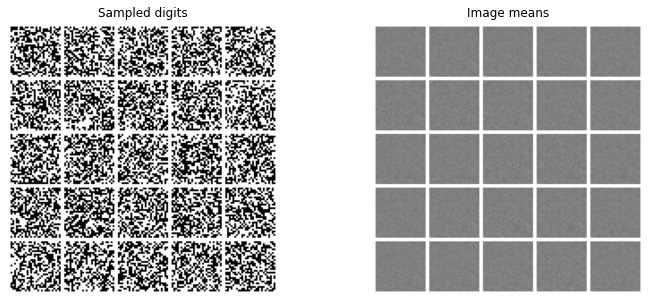


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 538.53 and recon loss 538.53 and KL loss -0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 0/235 with loss 543.64 and recon loss 543.64 and KL loss -0.00
Epoch: 0/0, i / N: 25/235 with loss 240.12 and recon loss 240.13 and KL loss -0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 208.51 and recon loss 208.42 and KL loss 0.10
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 50/235 with loss 206.65 and recon loss 206.56 and KL loss 0.08
Epoch: 0/0, i / N: 75/235 with loss 206.95 and recon loss 206.58 and KL loss 0.37

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 204.81 and recon loss 203.41 and KL loss 1.40
MC integration: 1.10 based on 50000 datapoints

Epoch: 0/0, i / N: 100/235 with loss 205.55 and recon loss 204.11 and KL loss 1.44
Epoch: 0/0, i / N: 125/235 with loss 202.61 and recon loss 200.62 and K

In [6]:
coupling_spline_flow = ModelVAE(num_dim_data = 784, 
                                h_dim=h_dim, 
                                z_dim=z_dim + 1, 
                                num_bins=num_bins,
                                num_centers=num_centers,  
                                num_flows=num_flows,
                                distribution='coupling_spline_flow')

coupling_spline_flow.to(device)

optimizer_coupling_spline_flow = optim.AdamW(coupling_spline_flow.parameters(), 
                                            lr=lr, 
                                            weight_decay=weight_decay)


print('##### Coupling Spline Flow VAE #####')

train_VAE(model=coupling_spline_flow, 
          optimizer=optimizer_coupling_spline_flow, 
          train_loader = train_loader, 
          config=config,
          epochs = epochs, 
          eval_iter = eval_iter,
          model_name='cou_s')

##### Cylindrical Moebius Flow VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (flow): Cylindrical_Flow(
    (mlp_body): MLP_body(
      (nn): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (scale): ModuleList(
      (0): _Cylindrical_Flow(
        (interval_spline): Interval_Spline_Flow(
          (params_predictor): MLP_simple_coupling(
            (input): Linear_conditional(
              (linear): Linear(in_features=4, out_features=128, bias=True)
              (cond_linear): Linear(in_features=128, out_features=128, bias=False)
            )
            (relu): ReLU()
            (out_widths): Linear_conditional(
              (linear): Linear(in_features=128, out_features=64, bias=True)
            )
            (out_heights): Linear_conditional(
              (linear): Linear(in_features=128, out_features=64, bias=True)
            )
            (out_derivatives): Linear_conditional(
        

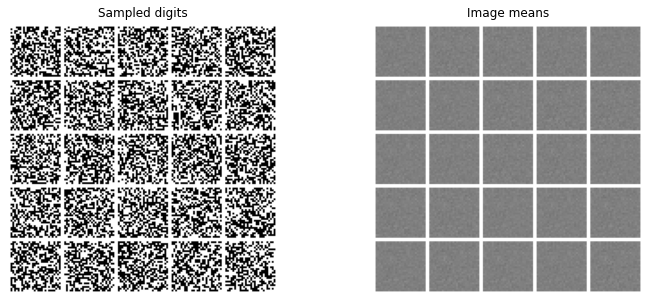


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 538.97 and recon loss 538.97 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 0/235 with loss 544.43 and recon loss 544.43 and KL loss 0.00
Epoch: 0/0, i / N: 25/235 with loss 233.25 and recon loss 233.25 and KL loss 0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 208.59 and recon loss 208.59 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 50/235 with loss 206.35 and recon loss 206.35 and KL loss -0.00
Epoch: 0/0, i / N: 75/235 with loss 206.66 and recon loss 206.66 and KL loss -0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 206.27 and recon loss 206.27 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 100/235 with loss 209.32 and recon loss 209.32 and KL loss 0.00
Epoch: 0/0, i / N: 125/235 with loss 207.56 and recon loss 207.56 and KL

In [7]:
cylindrical_moeb_flow = ModelVAE(num_dim_data = 784, 
                                 h_dim=h_dim, 
                                 z_dim=z_dim + 1, 
                                 num_bins=num_bins,
                                 num_centers=num_centers,
                                 num_flows=1,
                                 distribution='cylindrical_moebius_flow')

num_flows = 1

cylindrical_moeb_flow.to(device)

optimizer_cylindrical_moeb_flow = optim.AdamW(cylindrical_moeb_flow.parameters(), 
                                             lr=lr, 
                                             weight_decay=weight_decay)


print('##### Cylindrical Moebius Flow VAE #####')

train_VAE(model=cylindrical_moeb_flow, 
          optimizer=optimizer_cylindrical_moeb_flow, 
          train_loader=train_loader,
          config=config,
          epochs=epochs, 
          eval_iter = eval_iter,
          model_name='cyl_m')



##### Cylindrical Spline Flow VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (flow): Cylindrical_Flow(
    (mlp_body): MLP_body(
      (nn): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (scale): ModuleList(
      (0): _Cylindrical_Flow(
        (interval_spline): Interval_Spline_Flow(
          (params_predictor): MLP_simple_coupling(
            (input): Linear_conditional(
              (linear): Linear(in_features=4, out_features=128, bias=True)
              (cond_linear): Linear(in_features=128, out_features=128, bias=False)
            )
            (relu): ReLU()
            (out_widths): Linear_conditional(
              (linear): Linear(in_features=128, out_features=64, bias=True)
            )
            (out_heights): Linear_conditional(
              (linear): Linear(in_features=128, out_features=64, bias=True)
            )
            (out_derivatives): Linear_conditional(
        

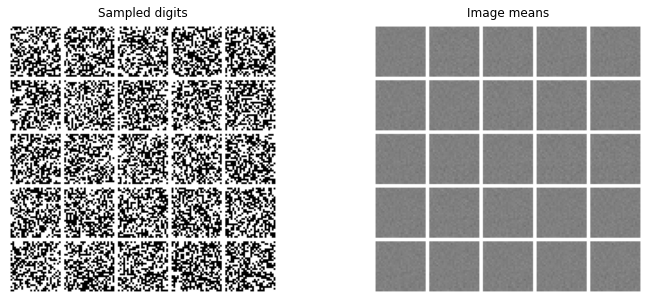


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 538.04 and recon loss 538.04 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 0/235 with loss 543.55 and recon loss 543.55 and KL loss 0.00
Epoch: 0/0, i / N: 25/235 with loss 228.83 and recon loss 228.81 and KL loss 0.02

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 208.51 and recon loss 208.51 and KL loss 0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 50/235 with loss 206.19 and recon loss 206.18 and KL loss 0.01
Epoch: 0/0, i / N: 75/235 with loss 204.61 and recon loss 204.61 and KL loss -0.00

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 206.57 and recon loss 206.57 and KL loss -0.00
MC integration: 1.00 based on 50000 datapoints

Epoch: 0/0, i / N: 100/235 with loss 206.67 and recon loss 206.67 and KL loss -0.00
Epoch: 0/0, i / N: 125/235 with loss 202.68 and recon loss 202.68 and K

In [8]:
cylindrical_spline_flow = ModelVAE(num_dim_data = 784, 
                                   h_dim=h_dim, 
                                   z_dim=z_dim + 1, 
                                   num_bins =num_bins,
                                   num_centers= num_centers,
                                   num_flows=1,
                                   distribution='cylindrical_spline_flow')

num_flows = 1

cylindrical_spline_flow.to(device)

optimizer_cylindrical_spline_flow = optim.AdamW(cylindrical_spline_flow.parameters(), 
                                               lr=lr,
                                               weight_decay=weight_decay)


print('##### Cylindrical Spline Flow VAE #####')

train_VAE(model=cylindrical_spline_flow, 
          optimizer=optimizer_cylindrical_spline_flow, 
          train_loader = train_loader, 
          config=config,
          epochs = epochs, 
          eval_iter = eval_iter,
          model_name='cyl_s')

### Train N-VAE and S-VAE

##### Normal VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (fc_e0): Linear(in_features=784, out_features=256, bias=True)
  (fc_e1): Linear(in_features=256, out_features=128, bias=True)
  (fc_mean): Linear(in_features=128, out_features=5, bias=True)
  (fc_var): Linear(in_features=128, out_features=5, bias=True)
  (fc_d0): Linear(in_features=5, out_features=128, bias=True)
  (fc_d1): Linear(in_features=128, out_features=256, bias=True)
  (fc_logits): Linear(in_features=256, out_features=784, bias=True)
)
##################

##### Config #####
{'BATCH_SIZE': 256,
 'HIDDEN_DIM_BASE_MLP': 128,
 'HIDDEN_DIM_MOEBIUS_MLP': 128,
 'HIDDEN_DIM_ROTATION_MLP': 128,
 'HIDDEN_DIM_SPLINE_MLP': 128,
 'H_DIM': 128,
 'NR_ROWS_TO_SAMPLE': 5,
 'NUM_BINS': 16,
 'NUM_CENTERS': 8,
 'NUM_FLOWS': 2,
 'Z_DIM': 5,
 'epochs': 1,
 'eval_iter': 25,
 'iters_per_epoch': 235,
 'lookahead': 20,
 'lr': 0.001,
 'test_set_eval_iter': 50,
 'weight_decay': 0.01}
##################

Epoch: 0/1


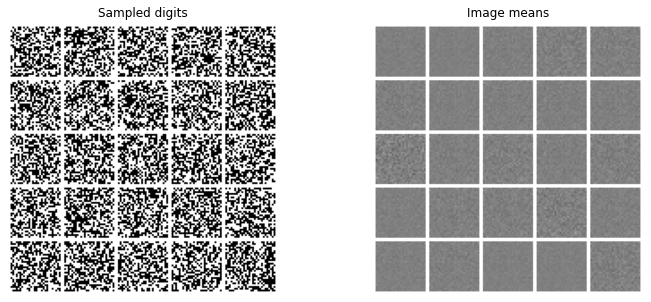


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 535.71 and recon loss 535.25 and KL loss 0.45

Epoch: 0/0, i / N: 0/235 with loss 543.26 and recon loss 542.72 and KL loss 0.54
Epoch: 0/0, i / N: 25/235 with loss 226.83 and recon loss 224.45 and KL loss 2.37

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 205.72 and recon loss 204.60 and KL loss 1.13

Epoch: 0/0, i / N: 50/235 with loss 212.80 and recon loss 211.73 and KL loss 1.07
Epoch: 0/0, i / N: 75/235 with loss 197.45 and recon loss 195.15 and KL loss 2.29

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 195.81 and recon loss 193.39 and KL loss 2.42

Epoch: 0/0, i / N: 100/235 with loss 196.45 and recon loss 193.98 and KL loss 2.48
Epoch: 0/0, i / N: 125/235 with loss 193.07 and recon loss 190.14 and KL loss 2.93

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 150/235 with loss 188.37 and recon loss 185.00 and KL loss 3.37

Epoch:

In [9]:
# normal VAE
modelN = ModelVAE(h_dim=h_dim, 
                  z_dim=z_dim, 
                  num_dim_data = 784, 
                  num_bins=None,
                  num_centers=None,
                  distribution='normal')


modelN.to(device)

optimizerN = optim.AdamW(modelN.parameters(),
                         lr=lr,
                         weight_decay=weight_decay)
                         

print('##### Normal VAE #####')

train_VAE(model=modelN, 
          optimizer=optimizerN, 
          train_loader = train_loader,
          config=config,
          epochs = epochs,
          eval_iter = eval_iter,
          model_name='modelN')


##### Hyper-spherical VAE #####


wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Model ######
ModelVAE(
  (fc_e0): Linear(in_features=784, out_features=256, bias=True)
  (fc_e1): Linear(in_features=256, out_features=128, bias=True)
  (fc_mean): Linear(in_features=128, out_features=6, bias=True)
  (fc_var): Linear(in_features=128, out_features=1, bias=True)
  (fc_d0): Linear(in_features=6, out_features=128, bias=True)
  (fc_d1): Linear(in_features=128, out_features=256, bias=True)
  (fc_logits): Linear(in_features=256, out_features=784, bias=True)
)
##################

##### Config #####
{'BATCH_SIZE': 256,
 'HIDDEN_DIM_BASE_MLP': 128,
 'HIDDEN_DIM_MOEBIUS_MLP': 128,
 'HIDDEN_DIM_ROTATION_MLP': 128,
 'HIDDEN_DIM_SPLINE_MLP': 128,
 'H_DIM': 128,
 'NR_ROWS_TO_SAMPLE': 5,
 'NUM_BINS': 16,
 'NUM_CENTERS': 8,
 'NUM_FLOWS': 2,
 'Z_DIM': 5,
 'epochs': 1,
 'eval_iter': 25,
 'iters_per_epoch': 235,
 'lookahead': 20,
 'lr': 0.001,
 'test_set_eval_iter': 50,
 'weight_decay': 0.01}
##################

Epoch: 0/1


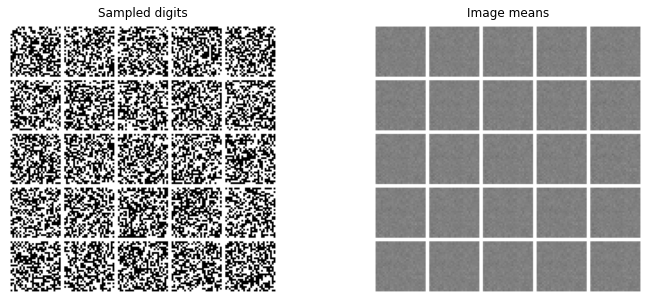


Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 0/235 with loss 537.61 and recon loss 537.39 and KL loss 0.22

Epoch: 0/0, i / N: 0/235 with loss 543.62 and recon loss 543.39 and KL loss 0.23
Epoch: 0/0, i / N: 25/235 with loss 236.69 and recon loss 236.45 and KL loss 0.24

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 50/235 with loss 208.32 and recon loss 208.22 and KL loss 0.10

Epoch: 0/0, i / N: 50/235 with loss 210.92 and recon loss 210.81 and KL loss 0.11
Epoch: 0/0, i / N: 75/235 with loss 205.36 and recon loss 205.26 and KL loss 0.09

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 100/235 with loss 206.64 and recon loss 206.54 and KL loss 0.10

Epoch: 0/0, i / N: 100/235 with loss 205.17 and recon loss 205.07 and KL loss 0.10
Epoch: 0/0, i / N: 125/235 with loss 204.29 and recon loss 204.18 and KL loss 0.11

Evaluation on test set with 10000 samples
Epoch: 0/0 i / N: 150/235 with loss 206.01 and recon loss 205.85 and KL loss 0.16

Epoch:

In [10]:
# hyper-spherical VAE
modelS = ModelVAE(h_dim=h_dim, 
                  z_dim=z_dim + 1, 
                  num_dim_data = 784,
                  num_bins=None,
                  num_centers=None,
                  distribution='vmf')

modelS.to(device)

optimizerS = optim.AdamW(modelS.parameters(),
                         lr=lr,
                         weight_decay=weight_decay)


print('##### Hyper-spherical VAE #####')


train_VAE(model=modelS, 
          optimizer=optimizerS,
          train_loader = train_loader, 
          config=config,
          epochs = epochs, 
          eval_iter = eval_iter,
          model_name='modelS')

